# 利確・トレーリング損切り戦略のバックテスト

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# バックテストの設定
# 評価期間の指定
start_date = '2020-10-01'
end_date = '2025-04-01'
# 利確と損切りの幅
profit_range = 0.1
loss_range = 0.05
# 銘柄の指定
# 銘柄の例(ETF) 1306:TOPIX連動, 1321:日経平均連動, 1546:ダウ工業株30種連動,
# 1557:SP500連動 1591:日経400連動, 2516:東証グロース250連動
ticker = '1557.T'
# トレンド識別手法
# 'MA_buy','MaMacd_buy','MaRsi_buy','BolRsi_buy','MaAdx_buy'のいずれか
id_trend = 'MA_buy'

In [3]:
# 株価データの獲得
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data.columns = [col[0] if isinstance(col, tuple) else col for col in stock_data.columns]
    stock_data['Returns'] = stock_data['Close'].pct_change()
    return stock_data

In [4]:
# 指標値の計算とシグナルの生成
def generate_signal(df, ma_fast=9, ma_middle=14, ma_slow=21, ma_superslow=50, 
                    macd_fast=12, macd_slow=26, macd_signal=9, rsi_period=14, 
                    bbands_period=5, bbands_std=2, adx_period=14):   
    # pandas_taライブラリによる各種指標の計算
    df['MA_Fast'] = df.ta.sma(close='Close', length=ma_fast)
    df['MA_Middle'] = df.ta.sma(close='Close', length=ma_middle)
    df['MA_Slow'] = df.ta.sma(close='Close', length=ma_slow)
    df['MA_Superslow'] = df.ta.sma(close='Close', length=ma_superslow)
    df.ta.macd(close='Close', fast=macd_fast, slow=macd_slow, signal=macd_signal, append=True)
    df['RSI'] = df.ta.rsi(close='Close', length=rsi_period)
    bbands = df.ta.bbands(close='Close', length=bbands_period, std=bbands_std)
    # 文字列をf''で囲い、その中で変数や式を{}で囲うことで、変数や式の値を文字列に埋め込むことができる。
    df['BB_upper'] = bbands[f'BBU_{bbands_period}_{bbands_std}.0']
    df['BB_middle'] = bbands[f'BBM_{bbands_period}_{bbands_std}.0']
    df['BB_lower'] = bbands[f'BBL_{bbands_period}_{bbands_std}.0']
    df['ADX'] = df.ta.adx(length=adx_period)[f'ADX_{adx_period}']
    # シグナルの判定
    # (1) 長短移動平均の位置関係
    df['MA_buy'] = df['MA_Fast'] > df['MA_Slow']
    df['MA_sell'] = df['MA_Fast'] < df['MA_Slow']
    # (2) 終値と長期移動平均の位置関係及びMACDとMACDsignalの位置関係
    macd_name = f'{macd_fast}_{macd_slow}_{macd_signal}'
    df['MaMacd_buy'] = (df['Close'] > df['MA_Superslow']) & (df[f'MACD_{macd_name}'] > df[f'MACDs_{macd_name}'])
    df['MaMacd_sell'] = (df['Close'] < df['MA_Superslow']) & (df[f'MACD_{macd_name}'] < df[f'MACDs_{macd_name}'])
    # (3) RSIの位置及び長短移動平均の位置関係
    df['MaRsi_buy'] = (df['RSI'] > 50) & (df['MA_Fast'] > df['MA_Slow'])
    df['MaRsi_sell'] = (df['RSI'] < 50) & (df['MA_Fast'] < df['MA_Slow'])
    # (4) 終値、ボリンジャーバンド、RSIの位置関係
    df['BolRsi_buy'] = (df['Close'] > df['BB_middle']) & (df['RSI'] > 50)
    df['BolRsi_sell'] = (df['Close'] < df['BB_middle']) & (df['RSI'] < 50)
    # (5) ADXの位置及び長短移動平均の位置関係
    df['MaAdx_buy'] = (df['ADX'] > 25) & (df['MA_Middle'] > df['MA_Superslow'])
    df['MaAdx_sell'] = (df['ADX'] > 25) & (df['MA_Middle'] < df['MA_Superslow'])
    # 特定の手法によるシグナルの生成（ここでは買いポジションのみをとる）
    df['Signal'] = 0
    df.loc[df[f'{id_trend}'], 'Signal'] = 1
    return df

In [5]:
# シグナルと終値からポジションを生成
def generate_position(df, price_col='Close', signal_col='Signal', position_col='Position',\
                      take_profit_pct=0.10, trailing_stop_pct=0.05):
    price_ary = df[price_col].to_numpy()
    signal_ary = df[signal_col].to_numpy()
    position_ary = np.zeros(len(df), dtype=int)
    # 初期設定
    entry_price = None # 買い参入時の価格
    in_position = False # 買いポジションを保持した状態かどうか
    trailing_stop = None # 現在の損切レベル
    take_profit = None # 利確レベル
    entry_index = None # 買いポジションをとった時点
    # シグナルと終値からポジションを生成する
    for i in range(len(df)):
        price = price_ary[i]
        position_ary[i] = int(in_position)
        # 買いポジションを保持しておらず買い条件を充足したとき
        if not in_position and signal_ary[i] == 1 :
            entry_price = price
            take_profit = entry_price * (1 + take_profit_pct)
            trailing_stop = entry_price * (1 - trailing_stop_pct)
            in_position = True
            position_ary[i] = 1
            entry_index = i
            continue
        # 買いポジションを保持しているとき
        if in_position:
            new_trailing_stop = price * (1 - trailing_stop_pct)
            trailing_stop = np.maximum(trailing_stop, new_trailing_stop) # 損切基準が上がったら書き換える
            # 利確又は損切で手仕舞い
            if price >= take_profit or price <= trailing_stop:
                in_position = False
                position_ary[i] = 0
                entry_price = None
                continue
    df[position_col] = position_ary
    return df

In [6]:
# バックテストの実施
def backtest_strategy(df, initial_balance=10000):
    # その日のポジションの符号と株価の変化率を乗じてリターンとする
    df['Daily_Return'] = df['Returns'] * df['Position'].shift()
    df['Portfolio_Value'] = (1 + df['Daily_Return']).cumprod() * initial_balance
    df.at[df.index[0], 'Portfolio_Value'] = initial_balance
    return df

# 結果のプロット
def plot_results(df):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    # Plot portfolio value on the primary y-axis
    ax1.plot(df.index, df['Portfolio_Value'], label='Portfolio Value', color='deepskyblue')
    ax1.set_ylabel('Portfolio Value', color='deepskyblue')
    ax1.tick_params(axis='y', labelcolor='deepskyblue')
    # Create a secondary y-axis for stock price
    ax2 = ax1.twinx()
    # Plotting the close price with the color corresponding to the trend
    for i in range(1, len(df)):
        ax2.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='darkgreen' if df['Position'].iloc[i] == 1 else 
                   ('red' if df['Position'].iloc[i] == -1 else 'darkgrey'), linewidth=2)
    ax2.set_ylabel('Stock Price', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')
    # Add title and legend
    fig.suptitle(ticker + ' Backtest (Green:buy Gray:nutral)')
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')
    plt.show()

# パフォーマンスの評価
def evaluate_performance(df):
    total_return = df['Portfolio_Value'].iloc[-1] / df['Portfolio_Value'].iloc[0] - 1
    volatility = df['Daily_Return'].std() * (252**0.5)
    sharpe_ratio = (df['Daily_Return'].mean() / df['Daily_Return'].std()) * (252**0.5)
    return {
        "Total Return": total_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio
    }

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


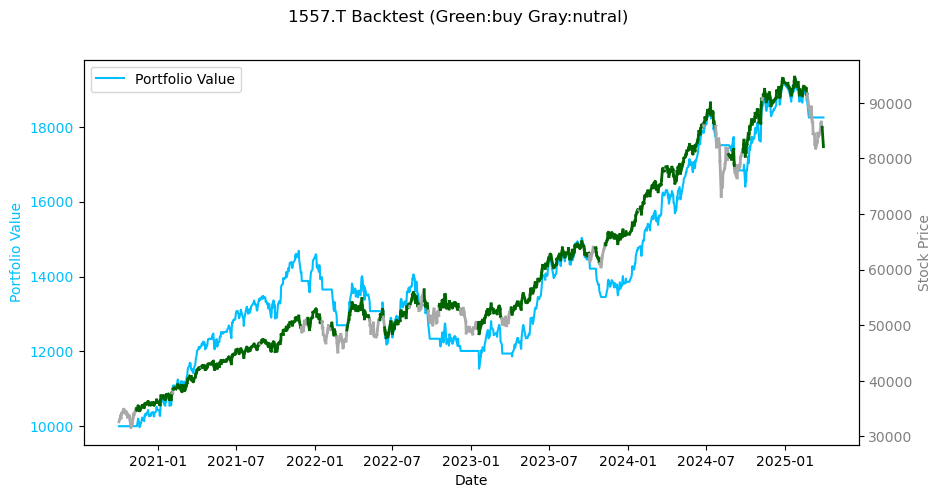

### BACKTEST RESULT ###
{'Total Return': 0.8249711000821092, 'Volatility': 0.14298083382362808, 'Sharpe Ratio': 1.0374096320138073}


In [7]:
# メインプログラム
data = fetch_stock_data(ticker, start_date, end_date)
data = generate_signal(data)
data = generate_position(data, take_profit_pct=profit_range, trailing_stop_pct=loss_range)
data = backtest_strategy(data)
plot_results(data)
performance = evaluate_performance(data)
print('### BACKTEST RESULT ###')
print(performance)